In [1]:
from desc import set_device
set_device("gpu")

In [2]:
import numpy as np
import os
# os.environ["JAX_LOG_COMPILES"] = "True"
from scipy.io import netcdf_file
import copy
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy.constants import mu_0
import sys
import functools
import pickle

import jax
import jax.numpy as jnp
from jax import jit, jacfwd

from netCDF4 import Dataset
import h5py

from desc.backend import put, fori_loop, jnp, sign

from desc.basis import FourierZernikeBasis, DoubleFourierSeries, FourierSeries
from desc.equilibrium import EquilibriaFamily, Equilibrium
from desc.grid import ConcentricGrid, LinearGrid, Grid, QuadratureGrid
from desc.io import InputReader, load
from desc.objectives import *
from desc.objectives.objective_funs import _Objective
from desc.plotting import plot_1d, plot_2d, plot_3d, plot_section, plot_surfaces, plot_comparison

from desc.plotting import *

from desc.transform import Transform
from desc.vmec import VMECIO
from desc.derivatives import Derivative
from desc.geometry import FourierRZToroidalSurface
from desc.profiles import SplineProfile, PowerSeriesProfile

from desc.magnetic_fields import ( SplineMagneticField, 
                                  #biot_savart_general, 
                                  FourierCurrentPotentialField, ToroidalMagneticField,
                                  field_line_integrate)

import desc.examples

from desc.backend import fori_loop, jit, jnp, odeint, sign
from desc.compute import rpz2xyz, rpz2xyz_vec, xyz2rpz, xyz2rpz_vec
from desc.coils import *

from desc.utils import Timer, copy_coeffs, errorif, setdefault, svd_inv_null, warnif
from desc.utils import flatten_list
from desc.utils import cross, dot

from desc.optimize import lsqtr, lsq_auglag

from scipy.optimize import NonlinearConstraint 

from desc.magnetic_fields import ( SplineMagneticField, 
                                  #biot_savart_general, 
                                  FourierCurrentPotentialField, ToroidalMagneticField,
                                  field_line_integrate)

import time

import numpy as np
from numpy.linalg import eig

from scipy.linalg import null_space
from numpy import ndarray

# Import my own functions
from desc.fns_simp import (_compute_magnetic_field_from_Current,
                           plot_figure,
                           plot_figure2,
                           plot_xy,
                           surf_int)

from desc.finite_diff_spe import first_derivative_t,first_derivative_z
                              #second_derivative_t,second_derivative_z,second_derivative_tz
#                             )

from desc.derivatives import Derivative
#from phi2d_eval import phi_sv_eval
#from contour_calc import contour_calc_c

In [3]:
#@jax.jit
def A_matrix(data, # Data on the winding surface
             y,
             _kgrid,
             _surf_winding,
             transform1,
             _eq,
             _egrid,
             _edata,
            ):
    
    b_mn = y#[0:data["theta"].shape[0]]
    
    fs = {"b_t": transform1.transform(b_mn, dt = 1),
          "b_z": transform1.transform(b_mn, dz = 1),
          }

    K_sv = cross(data["n_rho"], (fs["b_t"] * data["e^theta_s"].T + fs["b_z"] * data["e^zeta_s"].T).T)
    
    return dot(_edata["n_rho"],
               _compute_magnetic_field_from_Current( _kgrid, K_sv, _surf_winding, _eq, _egrid, basis = "rpz" )
              )

In [4]:
# Evaluate the solution
def sol_eval(grid, 
             data,
             basis_b,           
             y,
            ):

    trans = desc.transform.Transform(grid, basis_b, derivs=1, 
                                     rcond='auto', build=True, build_pinv=False, method='auto')
    
    # Compute V, rho and derivatives on the grid
    fs = {# First derivatives of a
        "b_t": desc.transform.Transform(grid = grid, basis = basis_b),
        "b_z": desc.transform.Transform(grid = grid, basis = basis_b),
    }
       
    b_mn = y
    ##
    fs["b_t"] = trans.transform(b_mn, dt=1, dz=0)
    fs["b_z"] = trans.transform(b_mn, dt=0, dz=1)
    
    return  cross(data["n_rho"], (fs["b_t"] * data["e^theta_s"].T + fs["b_z"] * data["e^zeta_s"].T).T)

(<Figure size 864x720 with 6 Axes>,
 array([<Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.167$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.333$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.500$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.667$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.833$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>],
       dtype=object))

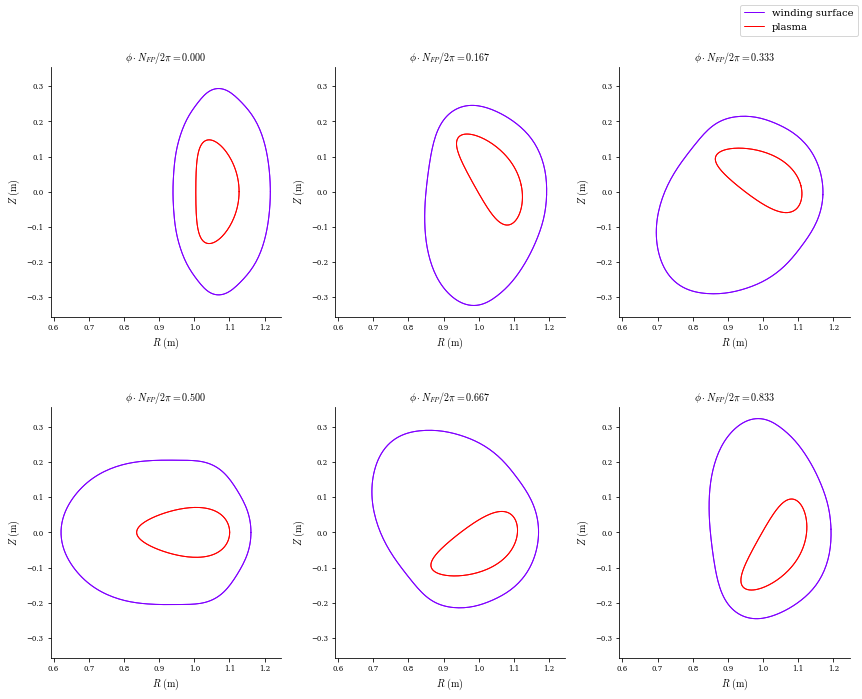

In [5]:
# Plasma surfaces
eqname_QA = "/scratch/gpfs/fcastro/LMStell/regcoil/rogerio/input.QA_final_output.h5" #vacuum equilibrium
eq_QA = desc.io.load(eqname_QA)[4]

eq = eq_QA  

# Winding surface
dir = '/home/fcastro/LMStell/sigma/RQA_RQH_18/'
surf_winding = load(dir + "surf_opt_1.h5")

# Plot both surfaces
plot_comparison([surf_winding,eq],labels=["winding surface","plasma"],theta=0,rho=np.array(1.0))
#plt.savefig("surfaces.png",dpi = 1200)

In [6]:
basis_M = 25
basis_N = 25
winding_surf = FourierCurrentPotentialField.from_surface(surf_winding,
                                                         M_Phi = basis_M,
                                                         N_Phi = basis_N,
                                                         )

In [7]:
kgrid = LinearGrid(M = 70, N = 70, 
                   NFP = winding_surf.NFP,
                  )
kdata = winding_surf.compute(["n_rho","H_1", "e^zeta_s"], grid = kgrid)

G = 0.8e6
np.save("G.npy",G)
#K_sec = G * cross(kdata["n_rho"], kdata["e^zeta_s"])
K_sec = G * cross(kdata["n_rho"], kdata["H_1"])

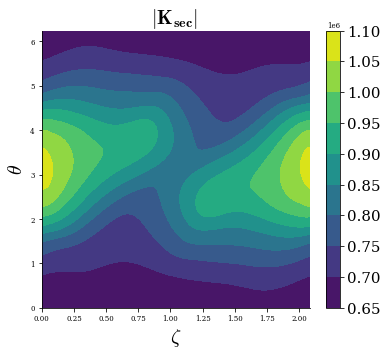

In [8]:
plot_figure2(dot(K_sec,K_sec )**(1/2),kgrid,''r'$|\mathbf{K_{sec}}|$ ')

In [9]:
egrid = LinearGrid(M = 50, N = 50, NFP = eq.NFP)
edata = eq.compute(["n_rho"], grid = egrid)

#B_s = eq.compute(["B"],grid = egrid)["B"]
B_sec = _compute_magnetic_field_from_Current( kgrid, K_sec, surf_winding, eq, egrid, basis = "rpz" )

#rhs = jnp.concatenate((B_s[:,0],B_s[:,1],B_s[:,2]))
Bn_sec = dot( edata["n_rho"],  B_sec )

In [10]:
alpha_v = [#1e-20,1e-19,
           1e-20,
           1e-17,
           #1e-15,1e-14,
           #1e-13,1e-12,
          ]

In [11]:
b_basis = DoubleFourierSeries(M = basis_M, N = basis_N, NFP = surf_winding.NFP, sym = "sin")
ktrans = Transform(kgrid, b_basis, derivs = 1, build=True,)
#xg = jnp.ones(b_basis.num_modes)
xg = winding_surf.Phi_mn

In [12]:
fun_wrapped = lambda xg: A_matrix(kdata, # Data on the winding surface
                                   xg,
                                   kgrid,
                                   surf_winding,
                                   ktrans,
                                   eq,
                                   egrid,
                                  edata,
                                   )

In [13]:
A = Derivative(fun_wrapped, deriv_mode="looped").compute(xg)

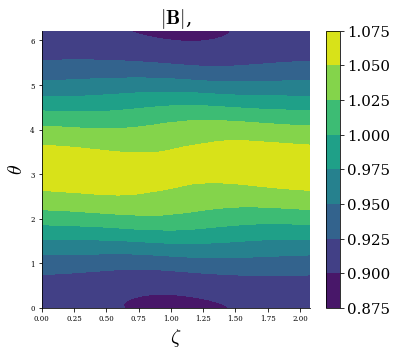

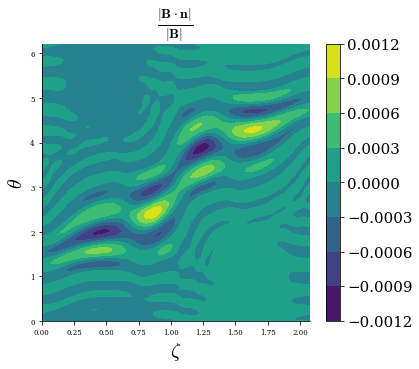

In [14]:
error_chi = []
b_chi = []

for i in range(0,1):

    #alpha = alpha_v[i]

    #rhs = - Bn_sec
    #soln = jnp.linalg.pinv(A) @ rhs

    alpha = 1e-12
    # calculate b_ij with SVD
    Ainv_full, _ = svd_inv_null(A.T @ A + alpha * jnp.eye(A.shape[1]))
    rhs = - Bn_sec @ A
    soln = Ainv_full @ rhs
    
    error = A@soln + Bn_sec

    winding_surf.Phi_mn = soln
    K_sol = winding_surf.compute(["K"],grid = kgrid)["K"]
    #K_sol = sol_eval(kgrid, kdata, b_basis, soln,)

    B_sol = _compute_magnetic_field_from_Current( kgrid, K_sec + K_sol, surf_winding, eq, egrid, basis = "rpz"
                                                )

    plot_figure2(dot(B_sol,B_sol)**(1/2),
                egrid,
                ''r'$|\mathbf{B}|$,')

    plot_figure2(error * dot(B_sol,B_sol)**(-1/2),
                egrid,
                ''r'$\frac{|\mathbf{B \cdot n}|}{|\mathbf{B}|}$')

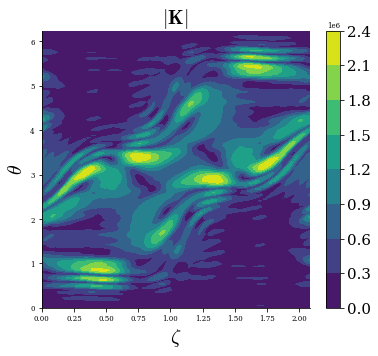

In [15]:
plot_figure2(dot(K_sol,K_sol)**(1/2),
                kgrid,
                ''r'$|\mathbf{K}|$')

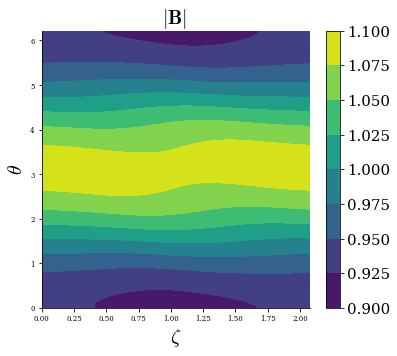

In [16]:
B_s = eq.compute(["|B|"],grid = egrid)["|B|"]

plot_figure2(B_s,egrid,''r'$|\mathbf{B}|$ ')

In [17]:
winding_surf.save("surf.h5")